In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
from IPython.display import clear_output
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta

# Importation des données et nettoyage

In [2]:
# Jointure entre le dataset des commandes, celui des payements, des produits et des notes de satisfactions.

# importations
orders = pd.read_csv(r"data/olist_orders_dataset.csv", encoding="utf-8")
order_items = pd.read_csv(r"data/olist_order_items_dataset.csv", encoding="utf-8")
order_payments = pd.read_csv(r"data/olist_order_payments_dataset.csv", encoding="utf-8")
order_reviews = pd.read_csv(r"data/olist_order_reviews_dataset.csv", encoding="utf-8")
products = pd.read_csv(r"data/olist_products_dataset.csv", encoding="utf-8")
category_translation = pd.read_csv(
    r"data/product_category_name_translation.csv", encoding="utf-8"
)

# Jointures
orders_1 = orders.merge(order_items, on=["order_id"], how="left")
orders_2 = orders_1.merge(order_payments, on=["order_id"], how="left")
orders_3 = orders_2.merge(order_reviews, on=["order_id"], how="left")
orders_4 = orders_3.merge(products, on=["product_id"], how="left")

# Traduction des catégories de produits
orders_4["product_category_name_english"] = orders_4["product_category_name"].map(
    category_translation.set_index("product_category_name")[
        "product_category_name_english"
    ]
)
orders_4 = orders_4.drop(columns=["product_category_name"])
orders_4 = orders_4.rename(
    columns={"product_category_name_english": "product_category_name"}
)

orders_info = orders_4

In [3]:
# Selection des variables pertinentes pour la segmentation client.
to_keep = [
    "order_id",
    "customer_id",
    "order_purchase_timestamp",
    "freight_value",
    "payment_value",
    "payment_installments",
    "review_score",
    "review_comment_message",
]
orders_model = orders_info[to_keep].copy(deep=True)
orders_model["order_purchase_timestamp"] = orders_model[
    "order_purchase_timestamp"
].apply(pd.to_datetime)

# Exploration des données

In [4]:
def date_df(date_serie):
    days = date_serie.apply(lambda d: d if d != d else d.day)
    month = {
        1: "jan",
        2: "feb",
        3: "mar",
        4: "apr",
        5: "may",
        6: "jun",
        7: "jul",
        8: "aug",
        9: "sep",
        10: "oct",
        11: "nov",
        12: "dec",
    }
    months = date_serie.apply(lambda d: d if d != d else month[d.month])
    years = date_serie.apply(lambda d: d if d != d else d.year)
    dates = pd.concat([days, months, years], axis=1).values
    order_purchase_date = pd.DataFrame(data=dates, columns=["day", "month", "year"])
    return order_purchase_date

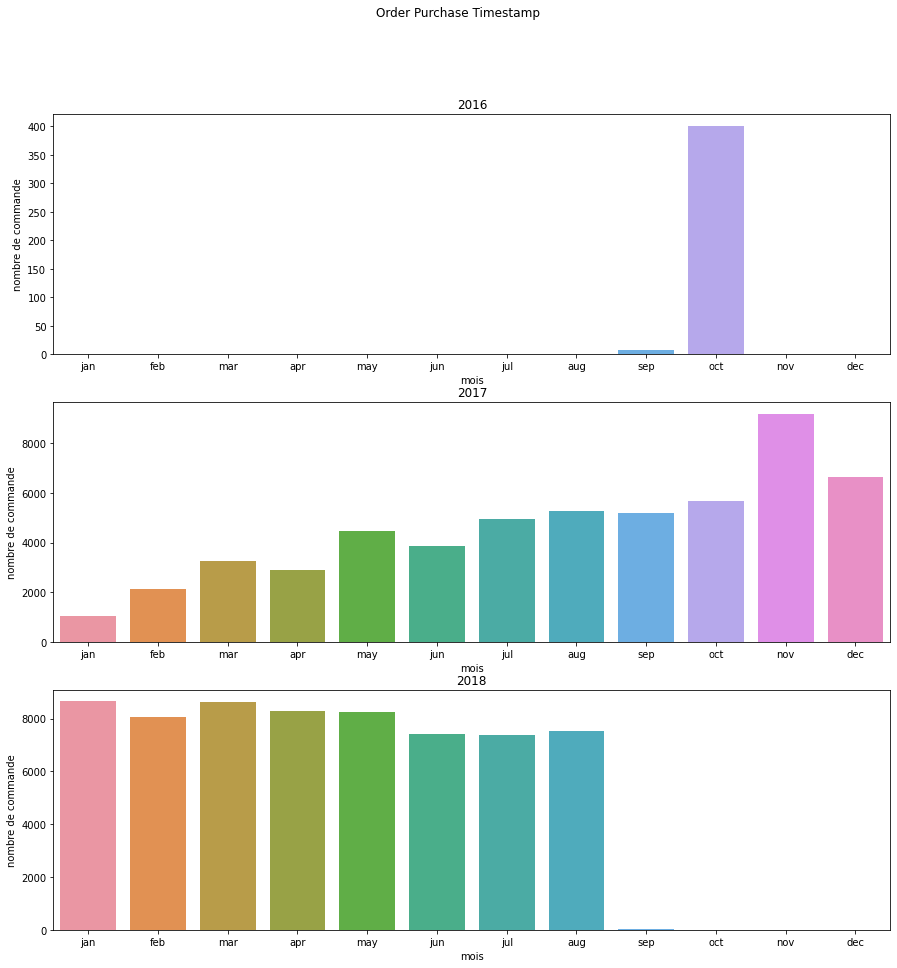

In [5]:
## Order purchase timestamp

# Il s'agit de l'heure de la validation de l'achat par l'internaute

order_purchase_date = date_df(orders_model["order_purchase_timestamp"])

liste_months = [
    "jan",
    "feb",
    "mar",
    "apr",
    "may",
    "jun",
    "jul",
    "aug",
    "sep",
    "oct",
    "nov",
    "dec",
]
count_2016 = []
count_2017 = []
count_2018 = []

for mon in liste_months:
    count_2016.append(
        order_purchase_date[
            (order_purchase_date["year"] == 2016)
            & (order_purchase_date["month"] == mon)
        ].shape[0]
    )
    count_2017.append(
        order_purchase_date[
            (order_purchase_date["year"] == 2017)
            & (order_purchase_date["month"] == mon)
        ].shape[0]
    )
    count_2018.append(
        order_purchase_date[
            (order_purchase_date["year"] == 2018)
            & (order_purchase_date["month"] == mon)
        ].shape[0]
    )

fig, ax = plt.subplots(3, 1, figsize=(15, 15))
sns.barplot(x=liste_months, y=count_2016, ax=ax[0])
ax[0].set_title("2016")
ax[0].set_xlabel("mois")
ax[0].set_ylabel("nombre de commande")
sns.barplot(x=liste_months, y=count_2017, ax=ax[1])
ax[1].set_title("2017")
ax[1].set_xlabel("mois")
ax[1].set_ylabel("nombre de commande")
sns.barplot(x=liste_months, y=count_2018, ax=ax[2])
ax[2].set_title("2018")
ax[2].set_xlabel("mois")
ax[2].set_ylabel("nombre de commande")
plt.suptitle("Order Purchase Timestamp")
plt.show()

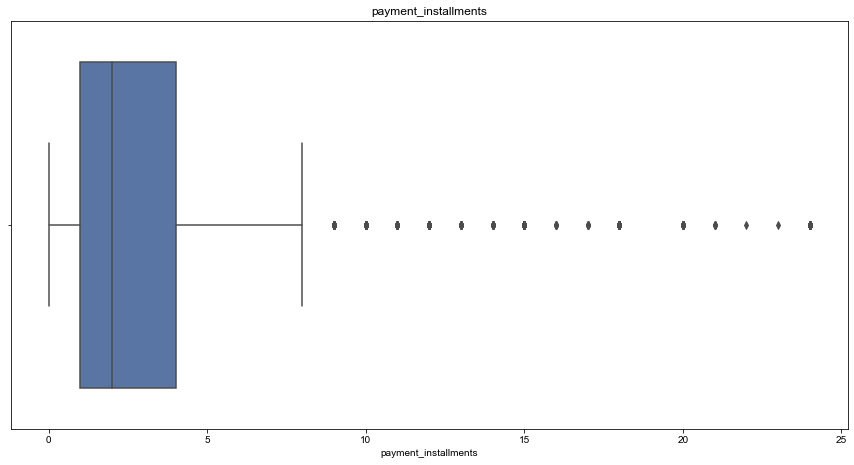

In [6]:
# Echéances de payements

fig, ax = plt.subplots(figsize=(15, 7.5))
sns.set_theme(style="whitegrid")
sns.boxplot(x=orders_model["payment_installments"], ax=ax)
plt.title("payment_installments")
plt.show()

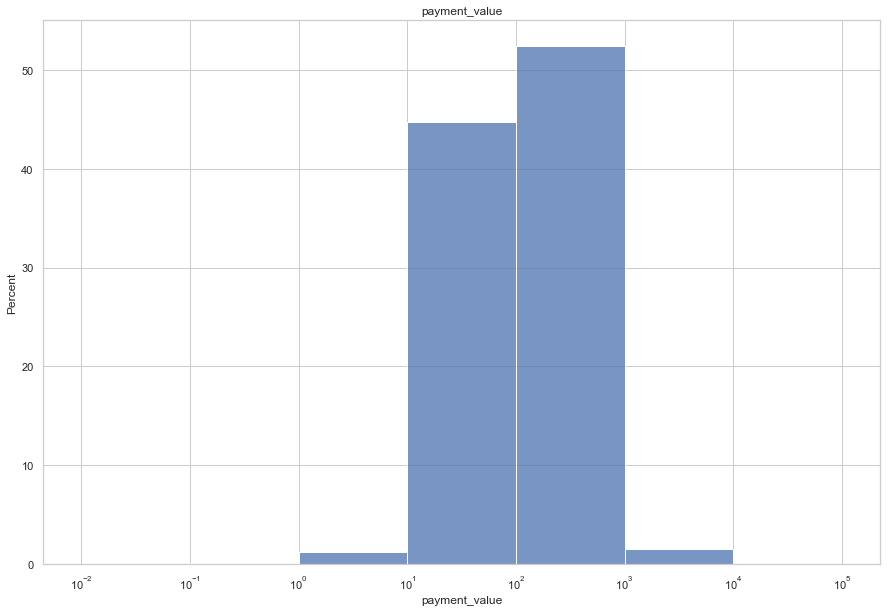

In [7]:
# Exploration des montants

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="white")
orders_model_0 = orders_model[orders_model["payment_value"] > 0].copy()
orders_model_0["payment_class"] = pd.cut(
    orders_model_0["payment_value"].values, 3
).astype("str")
sns.histplot(
    x="payment_value",
    data=orders_model_0,
    log_scale=True,
    stat="percent",
    binwidth=1,
    ax=ax,
)
plt.title("payment_value")
plt.show()

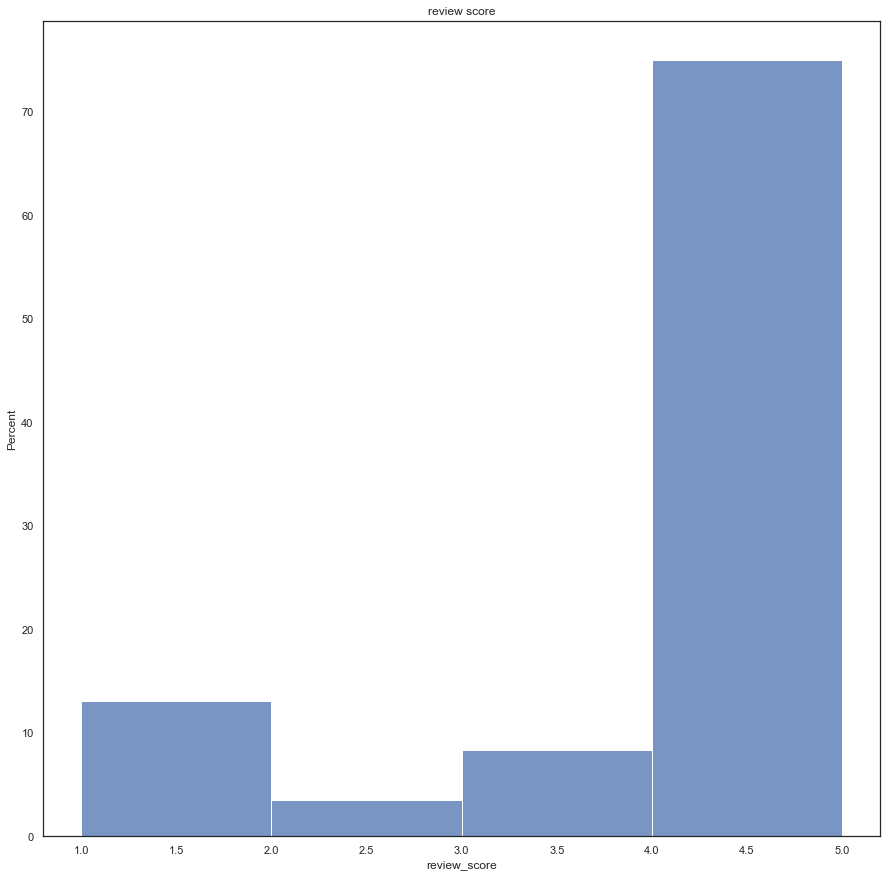

In [8]:
# Exploration de la note de satisfaction

fig, ax = plt.subplots(figsize=(15, 15))
sns.set_theme(style="white")
sns.histplot(x="review_score", data=orders_model, stat="percent", binwidth=1, ax=ax)
plt.title("review score")
plt.show()

# Construction de la base de client à partir de l'analyse RFM

In [11]:
def customers_dataset(orders_model, start_date, end_date):
    """
    Cette fonction permet de passer du dataset des commandes à celui des clients en exploitant le customer_id
    et le customer_unique_id.
    Les deux paramètres start_date et end_date permet de limiter les commande à celle ayant été réalisée entre ces
    deux dates.
    """
    # Filtrage sur la période souhaitée
    orders_update = orders_model[
        (orders_model["order_purchase_timestamp"] < end_date)
        & (orders_model["order_purchase_timestamp"] >= start_date)
    ]
    # Importation du dataset contenant les informations sur les clients
    customers = pd.read_csv(r"data/olist_customers_dataset.csv", encoding="utf-8")
    # Récupération des commandes réalisée par les clients
    customers = customers.merge(
        orders_update[
            [
                "customer_id",
                "order_purchase_timestamp",
                "payment_value",
                "payment_installments",
                "review_score",
            ]
        ],
        how="right",
        on=["customer_id"],
    )

    most_recent_date = orders_update[
        "order_purchase_timestamp"
    ].max()  # date de la commande la plus récente
    customers["recency_customer"] = (
        most_recent_date - customers["order_purchase_timestamp"]
    ).apply(lambda ts: ts.days)
    # Passage à une vision client unique.
    customers = customers.groupby(["customer_unique_id"]).agg(
        {
            "recency_customer": "mean",
            "customer_id": lambda x: len(np.unique(x)),
            "payment_value": "sum",
            "payment_installments": "mean",
            "review_score": "mean",
        }
    )
    customers = customers.rename(columns={"customer_id": "number_of_orders"})
    # Imputation des données manquantes
    customers["payment_installments"] = customers["payment_installments"].fillna(1)
    customers["review_score"] = customers["review_score"].fillna(
        customers["review_score"].mean()
    )
    customers = customers.reset_index()
    return customers

In [12]:
# Construction de la base client sur toute la période disponible.
complete_dataset = customers_dataset(
    orders_model,
    orders_model["order_purchase_timestamp"].min(),
    orders_model["order_purchase_timestamp"].max() + timedelta(seconds=1),
)

In [13]:
complete_dataset.head()

,customer_unique_id,recency_customer,number_of_orders,payment_value,payment_installments,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,160.0,1,141.90,8.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.0,1,27.19,1.0,4.0
2,0000f46a3911fa3c0805444483337064,585.0,1,86.22,8.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,369.0,1,43.62,4.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,336.0,1,196.89,6.0,5.0


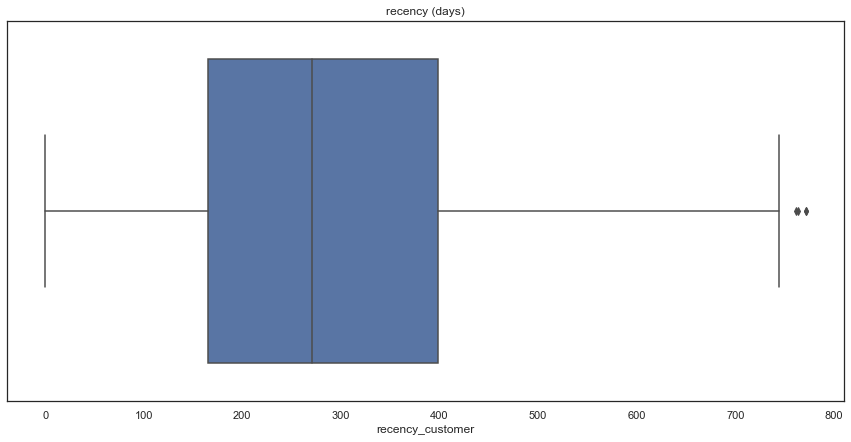

In [14]:
# Exploration de la récence

fig, ax = plt.subplots(figsize=(15, 7))
sns.set_theme(style="whitegrid")
sns.boxplot(x=complete_dataset["recency_customer"], ax=ax)
plt.title("recency (days)")
plt.show()

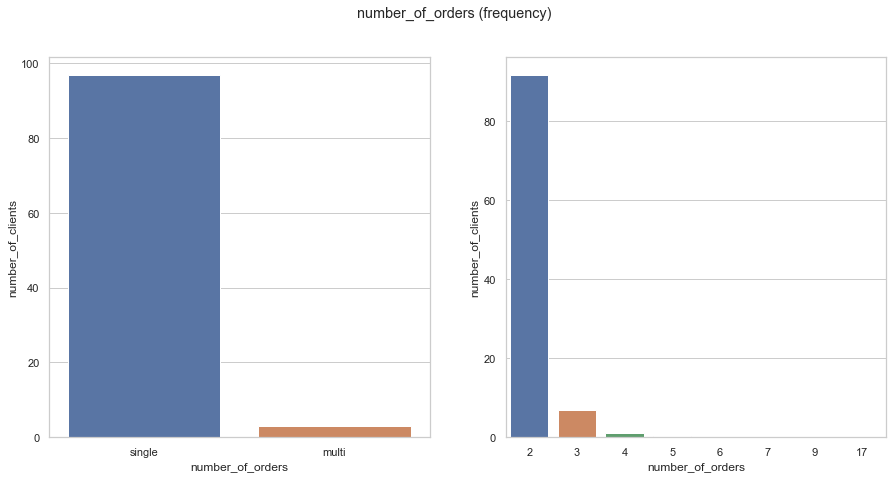

In [15]:
# Exploration de la fréquence

data_1 = complete_dataset["number_of_orders"].apply(
    lambda x: "single" if x == 1 else "multi"
).value_counts() / (0.01 * (complete_dataset.shape[0]))
data_1 = data_1.reset_index().rename(
    columns={"index": "number_of_orders", "number_of_orders": "number_of_clients"}
)

data_2 = complete_dataset[complete_dataset["number_of_orders"] != 1][
    "number_of_orders"
].value_counts() / (
    0.01 * (complete_dataset[complete_dataset["number_of_orders"] != 1].shape[0])
)
data_2 = data_2.reset_index().rename(
    columns={"index": "number_of_orders", "number_of_orders": "number_of_clients"}
)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.set_theme(style="whitegrid")
sns.barplot(x="number_of_orders", y="number_of_clients", data=data_1, ax=ax[0])
sns.barplot(x="number_of_orders", y="number_of_clients", data=data_2, ax=ax[1])
plt.suptitle("number_of_orders (frequency)")
plt.show()

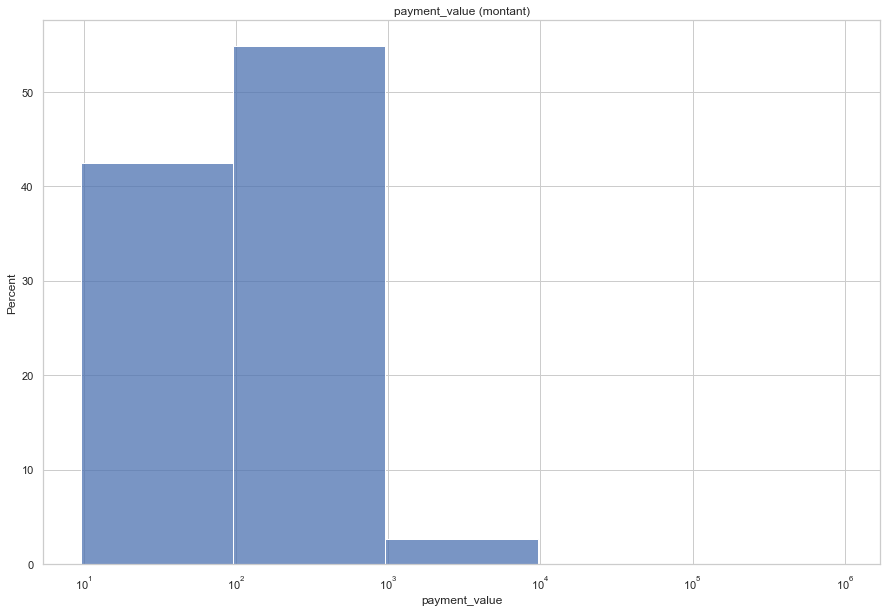

In [16]:
# Exploration des montants

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="white")
complete_dataset_0 = complete_dataset[complete_dataset["payment_value"] > 0].copy()
complete_dataset_0["payment_class"] = pd.cut(
    complete_dataset_0["payment_value"].values, 3
).astype("str")
sns.histplot(
    x="payment_value",
    data=complete_dataset_0,
    log_scale=True,
    stat="percent",
    binwidth=1,
    ax=ax,
)
plt.title("payment_value (montant)")
plt.show()

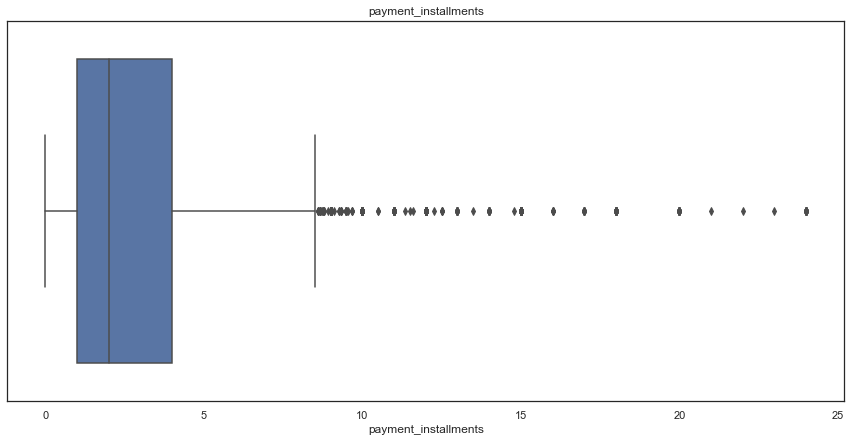

In [17]:
# Exploration des échéances de payements

fig, ax = plt.subplots(figsize=(15, 7))
sns.set_theme(style="whitegrid")
sns.boxplot(x=complete_dataset["payment_installments"], ax=ax)
plt.title("payment_installments")
plt.show()

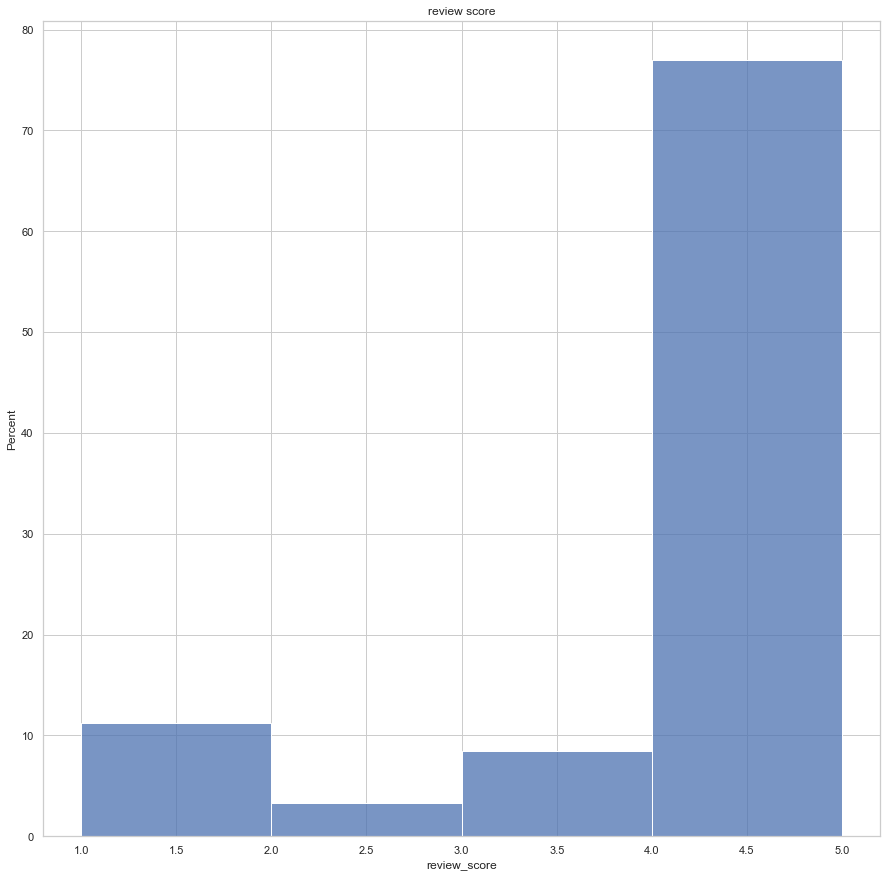

In [18]:
# Exploration de la note de satisfaction

fig, ax = plt.subplots(figsize=(15, 15))
sns.set_theme(style="white")
sns.histplot(x="review_score", data=complete_dataset, stat="percent", binwidth=1, ax=ax)
plt.title("review score")
plt.show()

In [19]:
complete_dataset.to_csv("data/customers_cleaned_2.csv", index = False)